<h1><center>  Project - Compressed Sensing - 2018-2019 </center></h1>



<h2><center>  Optimization via Low Rank Approximation for Community Detection in Networks [1] <br> & <br> 
    Community Detection in Sparse Networks via Grothendieck's Inequality [2]
    </center></h2>
<img src="ENSAE.jpg" width="300">
<h3>  <p style="text-align:left;">Authors: <span style="float:right;"> Professor:<br>
    <br> Guillaume Lecué 
</span></p>

Damien Grasset <br> Thibault Randrianarisoa </h3>


________________

# Outline

## <a href="#1.-Introduction " style="color:#00925B">1.&nbsp;&nbsp;Introduction</a>

## <a href="#2.-Graph-modelisation" style="color:#00925B">2.&nbsp;&nbsp;Random Graph modelisation </a>

-  <a href="#Stochastic-Block-Model-(SBM)-and-Degree-Corrected-SBM-(DCSBM)" style="color:#00925B">2.1&nbsp;&nbsp;Stochastic Block Model and Degree-Corrected SBM </a>

-  <a href="#Visualization" style="color:#00925B">2.2&nbsp;&nbsp;Visualization</a>

## <a href="#3.-Different-strategies-to-solve-the-communities-detection-problem" style="color:#00925B">3.&nbsp;&nbsp;Strategies to solve the communities detection problem </a>

## <a href="#4.-Application-to-Community-Detection-in-Networks." style="color:#00925B">4.&nbsp;&nbsp;Application to Community Detection in Networks </a>

-  <a href="#A.-Regularized-Spectral-Clustering-(SCR)" style="color:#00925B">4.1.&nbsp;&nbsp;Regularized Spectral Clustering (SCR)</a>

-  <a href="#B.-Approximate-Extreme-Points-(AEP)" style="color:#00925B">4.2.&nbsp;&nbsp;Approximate Extreme Points (AEP) </a>

-  <a href="#C.-Extreme-Points-(EP)" style="color:#00925B">4.3.&nbsp;&nbsp;Extreme Points (EP) </a>
-  <a href="#D.-Unconditional-Pseudo-Likelihood-(UPL)" style="color:#00925B">4.4.&nbsp;&nbsp;Unconditional Pseudo-Likelihood (UPL)</a>
-  <a href="#E.-Conditional-Pseudo-Likelihood-(CPL)" style="color:#00925B">4.5.&nbsp;&nbsp;Conditional Pseudo-Likelihood (CPL) </a>
-  <a href="#F.-SDP-optimization-(SDP)" style="color:#00925B">4.6.&nbsp;&nbsp;SDP Optimization (SDP) </a>

-  <a href="#Numerical-comparaison-of-the-different-procedures" style="color:#00925B">4.7.&nbsp;&nbsp;Numerical comparaison of the different procedures </a>


## <a href="#5.-Real-word-network-Data-:-PolBlogs" style="color:#00925B">5.&nbsp;&nbsp;Real-word network Data : PolBlogs</a>

___________________

## 1. Introduction 

The two papers under scrutiny expound general methods to deal with optimization problems indexed by random matrices. More particularly, the authors are interested in the maximization of functions of the adjacency matrix of random graphs. It is of particular interest as the analysis of networks and, above all the discovering communities within networks, appears in several fields (statistics, physics, sociology...) and has diverse applications.

Detection network community structure consists in infering a label vector $c \in \{1,....,K\}^n$ for the n nodes of the network ($K$ being the number of communities, $c_i$ is the community of the node $i$), to which we associate an adjency matrix $A \in \mathcal{M}_{n\times n}$ defined as follow : 
$$ \left\{ \begin{array}{cc}
A_{ij} = 1 & \mbox{ if there is an edge from i to j}\\
A_{ij} = 0 & \mbox{ otherwise}
\end{array}\right.$$

In the papers, the authors focus on a specific type of network, making the hypotheses that **K is given** and the network is **undirected** (which means that the adjency matrix $A$ associated to the network is symmetric) and **unweigthed** (the matrix $A$ has its components in $\{0;1\}$).
In order to solve such problem, the detection methods either fit probabilistic models for the adjency matrix $A$ or use algorithmic approaches to optimize global criteria derived from other considerations over the label assignments $c$ (ex: spectral approximation). We will present examples of both these strategies in what follows.

In [2]:
# Packages 

import warnings
warnings.filterwarnings("ignore")

import os
import time
import tqdm
import scipy
import numpy as np
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

from scipy.sparse.linalg import eigsh

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from scipy.cluster.vq import whiten, kmeans
from numpy import linalg as LA
from networkx.algorithms.cuts import conductance

from joblib import Parallel, delayed
import multiprocessing

from random import sample
from cmath import phase

# Parametrization 

n = 300
K = 2
gamma = 0.5
pi = 0.5

lambda_n = 15
eps = 0.5
tau = eps * lambda_n /n
r = 0.3
w1 = 1
w2 = 1


np.random.seed(7)

## 2. Graph modelisation

First of all, let's introduce two types of Random Graphs : the **Stochastic Block Model** and the **Degree-Corrected SBM**.

### Stochastic Block Model (SBM) and Degree-Corrected SBM (DCSBM)

The **SBM**, as seen in class, is a random graph G ~ G(n,p,q), such that $0 \leq q < p \leq 1$, whose parameters meanings are: 
- $n \in \mathbb{N}^{*}$ : the number of nodes in the graph.
- $p$ : the density parameter of egdes within communities. Two nodes from the same community are connected with an edge with probability $p$.
- $q$ : the density parameter of egdes between communities. Two nodes from different communities are connected with probability $q$.

Given those parameters, the random graph is generated as follows: 
- draw a partition $V_1 \cup ... \cup V_k = \{1,..., n\}$ of K communities among all nodes (remind that here we focus on K=2).
- draw the adjency matrix $A \in \mathbb{R}^{n\times n}$ such that $A_{ij} = A_{ji} \mbox{ and } A_{ii} = 1$ and: 

$$ i>j , \space A_{ij} \overset{\text{iid}}{\sim}  \left\{ \begin{array}{lcl}
Ber(p) & \mbox{ if } &  i \sim j \mbox{ and } i \neq j\\
Ber(q) & \mbox{ if } & i\not \sim j
\end{array}\right.$$

Here, $i \sim j$ means that nodes $i$ and $j$ belong to the same communities.

The **Degree-Corrected SBM** is very similar to the standard SBM, in the sense that it needs the parameters n, p and q, but add an extra parameter $\theta = (\theta_1,..., \theta_n)$ that aims at "correcting" the degree of each node $i \in \{1, ..., n\}$. Indeed, on the contrary to the previous model, it allows the existence of 'hub' nodes. These nodes are particularly well-connected to many nodes across the network (in comparison to other, more regular, nodes in the network). The graph is then generated like before, with the two following extra steps: 

- draw the node degree parameters $(\theta_i)_{i=1}^n$ as iid samples from a certain distribution. In the article [1], they choose to use a specific setting for the generation of $\theta$, that we will directly use for the parametrization of our application: the $\theta_i$'s are drawn from the distribution $\mathcal{P}(\theta = 0.2) = \lambda$ and $\mathcal{P}(\theta = 1) = 1 - \lambda $
    
- Another extra step is needed here. If we note $P_0 = \left(\begin{array}{cc} w_1 & r \\ r & w_2 \end{array}\right)$ with $r$ the out-in probability ratio and $(w_1, w_2)$ controlling the relative node degrees within communities, this matrix itself controls the probability matrix $P= \left(\begin{array}{cc} p & q \\ q & p \end{array}\right)$. So as to keep in check the expected degree of nodes, the authors of [1] propound to rescale the matrix $P_0$ and then take: 
$$ P = \frac{\lambda P_0}{(n-1)(\pi^T P_0 \pi)(\mathbb{E}(\theta))^2} $$

with $\pi = n^{-1}(n_1, n_2)$ is the frequency vector of the two communities, and $n_k$ the number of nodes in community $k$.

As a remark, this transformation can be simplified if we state that $\mathcal{E}(\theta_i) = 1$ and each of the two communities have the same number of nodes :

$$ \hat{P} = \frac{2\lambda P_0}{(n-1)(p+q)} $$
   
Then, edges are generated in a similar way to SBM, but including the node degree parameters $\theta_i$ and $\theta_j$ of each pair of nodes : 
- draw a partition $V_1 \cup ... \cup V_k = \{1,..., n\}$ of K communities among all nodes.
- draw the adjency matrix $ A \in \mathbb{R}^{n\times n}$ such that $ A_{ij} = A_{ji} \mbox{ and } A_{ii} = 1$ and: 

$$ i>j ,  \space A_{ij}  \left\{ \begin{array}{lcl}
\mathbb{P}(\space A_{ij} = 1)  = \theta_i \theta_j \hat{p} & \mbox{ if } &  i \sim j \mbox{ and } i \neq j\\
\mathbb{P}(\space A_{ij} = 0)  = \theta_i \theta_j  \hat{q} & \mbox{ if } & i\not \sim j
\end{array}\right.$$



Fitting these models calls for the maximization of a likelihood function over all possible label assigments which is NP-Hard in practice. Therefore, we will expound some other strategies to recover the communities in what follows.

In [3]:
class Graph_Model():
    
    """
    Graph class for simulations.
    Create graph from SBM and DCSBM models with two communities (gamma=0 gives the SBM).
    """
    
    def __init__(self, n, r, w1, w2, lambda_n, pi, gamma):
        
        # Attributes defining the model
        self.n = n  # nodes count
        self.r = r  # out-in probability ratio
        self.w1 = w1  # weight of first community
        self.w2 = w2  # weight of second community
        self.lambda_n = lambda_n  # overall expected network degree
        self.pi = pi  # expected fraction of nodes from first community
        self.gamma = gamma  # probability of node degree parameter being equal to 0.2. Equal 1 otherwise.
        
        # community vector
        # With K = 2, it can be seen as a draw from a binomial distribution
        if self.pi>0:  # drawing nodes community from binomials
            pi_ = np.random.binomial(n, pi) # count of nodes from first community
            index_ = sample(range(0, n), pi_)
            self.labels = [-1 if i in index_ else 1 for i in range(n)]
            self.count_first = len(index_)
        else: # for balanced planted model
            self.labels = [-1 if i<=n//2 else 1 for i in range(1,n+1)]  # first half of nodes are in the first community
            self.count_first = n//2
        
        # node degree parameters
        if gamma == 0:  # gives the SBM
            self.nd = [1]*n
        else:  # DCSBM
            self.nd = [0.8*np.random.binomial(1,gamma)+0.2 for _ in range(self.n)]
                        
        # Probability matrix
        repart_comm = (1/self.n)*np.array([self.count_first,n-self.count_first])  # community proportions
        self.P0 = np.array([[w1,r],[r,w2]])
        self.probas = lambda_n * self.P0 /\
            ((self.n-1)*((1-0.8*gamma)**2)*\
             (np.dot(
            np.dot(repart_comm, self.P0), repart_comm)
             )
            )  # normalisation as suggested in [1]
        
        self.adjency_matrix = np.identity(n)
        self.edges = []
        self.get_adjency_edges()

    def get_adjency_edges(self):

        ''' Construct the Adjency Matrix by drawing edges according the model probabilities '''

        for i in range(self.n):
            for j in range(i):
                ci, cj = self.labels[i], self.labels[j]
                edge = np.random.binomial(1,self.nd[i]*self.nd[j]*self.probas[(1+ci)//2, (1+cj)//2])
                if edge:
                    self.edges.append((i,j))
                    self.adjency_matrix[i,j], self.adjency_matrix[j,i] = 1, 1
                    
    def NMI(self, c):
        
        ''' Normalized Mutual Score between an estimation and the real label vector'''
        
        return(
            normalized_mutual_info_score(
                labels_true = self.labels, labels_pred = c,
                average_method='arithmetic')
        )
    
    def count_misfits(self):      

        ''' Count the number of isolated nodes in the graph. This happens a lot with graph with few nodes.
            It can impact the efficiency of method such as EP without regularization.'''

        count = 0
        for i in range(self.n):
            if self.adjency_matrix[i,:].sum()==1  :
                count+=1
        return count
    
    def OKL(self, e, comm1, comm2):
        '''Return the number of edges between community comm1 and comm2'''
        
        indice_1 = [index for index, comm in enumerate(e) if comm == comm1]
        indice_2 = [index for index, comm in enumerate(e) if comm == comm2]
        
        return np.sum([self.adjency_matrix[i1, i2] for i1 in indice_1 for i2 in indice_2])
    
    def OK(self, e, comm):
        return np.sum([self.OKL(e, comm, comm_) for comm_ in set(e)])
    
    def comm_effectif(self, e, comm):
        return(np.sum([comm_==comm for comm_ in e]))

    def sbm_proflikelihood(self, e):
        '''profile likelihood of the SBM'''
        qbm = 0
        communities = set(e)
        for i in communities:
            for j in communities:
                qbm += self.OKL(e,i,j)*np.log(self.OKL(e,i,j)/(self.comm_effectif(e,i)*self.comm_effectif(e,i)))
        return(qbm)
    
    def dcsbm_proflikelihood(self, e):
        '''profile likelihood of the DCSBM'''
        qdc = 0
        communities = set(e)
        for i in communities:
            for j in communities:
                qdc += self.OKL(e,i,j)*np.log(self.OKL(e,i,j)/(self.OK(e,i)*self.OK(e,i)))
        return(qdc)
    
    def NG_mod(self, e):
        '''Newman-Girvan modularity'''
        qng = 0
        communities = set(e)
        m = np.sum(self.adjency_matrix)
        for i in communities:
            qng += self.OKL(e,i,i) - self.OK(e,i)**2/m
        return(qng/(2*m))
    
    def Extraction_criteria(self, e):
        """Community extraction criteria. Note that this implementation is correct only in the case
        of 2 communities which is what we're interested in here."""
        n = len(e)

        index_comm = [index for index, comm in enumerate(e) if comm == 1]
        O = np.sum([self.adjency_matrix[i][j] for i in index_comm for j in index_comm])
        B = np.sum([self.adjency_matrix[i][j] for i in index_comm for j in list(set(list(range(n))) - set(index_comm))])

        V = len(index_comm)
        if V==0:
            return 0
        
        Vc = n-V

        return( Vc*O/V - B )

In [4]:
graph = Graph_Model(n = 30, lambda_n = 1.5, r = 0.3, w1=1, w2=3, gamma=0, pi=0.5) #SBM
graph = Graph_Model(n = 30, lambda_n = 1.5, r = 0.3, w1=1, w2=3, gamma=0.5, pi=0.5)  #DCSBM

### Visualization

Let's define one function that will enable us to plot and vizualise the generated networks.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_network(graph, graph_layout='random'):

    '''Plot function to vizualise Generated Networks '''
    
    # Parameters for the graph plot
    node_size=100
    node_color='black'
    node_alpha=0.8
    node_text_size=6
    edge_color='black'
    edge_alpha=0.1
    edge_tickness=1
    text_font='sans-serif'

    # create networkx graph
    G=nx.Graph()

    for node in range(graph.n):
        G.add_node(node)
    for edge in graph.edges:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # Draw graphs
    plt.figure(figsize=(20,5))
    
    # Observed network
    plt.subplot(121)
    plt.title('Observed network')


    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    
    # With the communities highlighten
    plt.subplot(122)
    plt.title('Network with actual communities')
    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=[node for node,label in enumerate(graph.labels) if label==-1],
                           node_color='r',
                           node_size=node_size,
                           alpha=node_alpha) # first community

    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=[node for node,label in enumerate(graph.labels) if label==1],
                           node_color='b',
                           node_size=node_size,
                           alpha=node_alpha)  # second community

    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)

    plt.show()

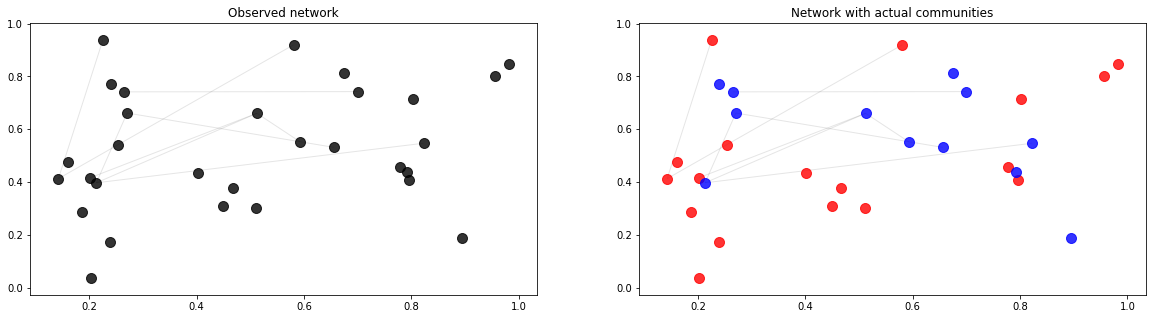

In [6]:
plot_network(graph)

## 3. Different strategies to solve the communities detection problem

In the papers, authors are interested in maximimizing several criteria:
- **resolution of a semidefinite optimization problem in [2]**
- **maximizing the profile likelihood of the degree-corrected SBM (DCSBM)**
- **maximizing the profile likelihood of the SBM.**
- **maximizing the the Newman-Girvan modularity**
- **maximizing the the community extraction criterion**

In this work, we will focus on the three first optimization problems. Still, we will present all of these below.

**Modularity** : 

This criterion relies on the comparison between the observed network and a null model that has no community structure. More particularly, the Newman-Girvan Modularity compares the observed number of edges within communities to the number that would be expected under the Chung-Lu model for the entire graph. With the following notations, 
- $e$ be an n-dimensional label vector.
- $n_k(e) = \sum_{i=1}^n I(e_i=k)$ nb of nodes in the community k
- $O_{kl}(e) = \sum_{i=1}^n\sum_{j=1}^n A_{ij}I(e_i=k, e_j=l)$ nb of edges between communities k and l ($k \ne l$)
- $O_k = \sum_{l=1}^K O_{kl}$ the sum of node degrees in community k 
- $d_i = \sum_{j=1}^n A_{ij}$ degree of node i 
- $m = \sum_{i=1}^n d_i$ (twice) the total of number of edges in the graph

the modularity is given by

$$ Q_{NG}(e) = \frac{1}{2m} \sum_k (O_{kk} - \frac{O_k^2}{m})$$


**Profile likelihoods of SBM and DCSBM**: 

When the likelihood function depends on many parameters, there is possibly only a subset of these parameters that are of interest. It may then be possibble to reduce the number of uninteresting (nuisance) parameters, taking them as functions of the parameters of interest. For instance, the functions might be the value of the nuisance parameter which maximizes the likelihood given the value of the other (interesting) parameters.

This procedure is called concentration of the parameters and results in the concentrated likelihood function, also often called the **profile likelihood function**. It is then possible (and simpler) to find the values of the parameters which maximizes the profile likelihood function (similar to the maximum likelihood). The profile likelihoods of the two models detailed above are provided there:

$$ Q_{BM}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{n_kn_l} $$
$$ Q_{DC}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{O_kO_l} $$

**Extraction Criteria** :

This criterion is motivated by the intuitive definition of community as a tightly knit group rather than by fitting a probability model to the network. This recognizes that some nodes may not belong to any community and the strength of a community should depend on ties between its members and ties to the outside world (but not on ties between non-members). The criterion value is given by:

$$Q_{EX}(V) = |V||V^c|\left(\frac{O(V)}{|V|^2} - \frac{B(V)}{|V||V^c|}\right)$$

where : 
- V : the set of nodes in the community to be extracted
- $V^c$ complement of V
- $O(V) = \sum_{i,j \in V} A_{ij}$
- $B(V) = \sum_{i \in V, j \in V^c} A_{ij}$

The optimization of this criterion can be done via greedy label switching (ex : via tabu seach algorithm).

**Semidefinite optimization**

The idea, developed in [2], consists in solving the problem:

$$\hat{Z}\in\underset{Z\succeq0,\quad diag(Z)\preceq I_n}{max}<A,Z>-\lambda<E_n,Z>$$

where $<A,B>=Tr(A^T B)$, $I_n$ is the identity matrix of size $n$, $E_n$ is matrix of all ones and $\lambda=\frac{2}{n(n-1)}\sum_{i<j}a_{ij}$ is the average degree of the graph.

The estimated community vector is then $sign(\hat{x})$ where $\hat{x}$ is the eigenvector of $\hat{Z}$ associated to the largest eigenvalue.

**Contribution of paper** :

The paper [1] develops a new method to optimize a function over discrete labels $e$ when this function depends on a network adjacency matrix $A$. The method developed relies on the fact that, for a family of function satisfying some conditions presented below, the objective depends only on the projection of $e$, $U_Ae$, on a low-dimensional space. Here, $U_A$ typically approximates the row space of $A$. Reducing the problem in this way, one avoids the need to evaluate the function at all possibles label assignments (combinatorial problem). Instead, when the projection space is two-dimensional for instance, the set of points that need to be checked is of linear size. The complexity of the algorithm is then much lower.

In practice, the issue the paper tackle is the problem of maximizing $f_B$, whose solution will be noted as $c$, when we only have access to $f_A$. The results in the article are thus general but are particularly interesting when $A$ is the adjacency matrix of a graph and $B=\mathbb{E}A$ is its expectation. The authors then derive bounds on the error made when one aims at solving the problem involving $A$ with the method developed below, whereas we are more interested in the solution of the problem involving $B$.

In the following, note that each quantities presented with a subscript $A$ will have its counterpart with subscript $B$. First, let's assume that $B$ is of rank $m$. The functions involved here are assumed to satisfy the following hypotheses:

0. $f_A(e)=\sum_{j=1}^\kappa g_j(h_{A,j}(e))$, for some $\kappa$, where $g_j$ is a scalar function and $h_{A,j}(e)=(e+s{j1})^TA(e + s_{j2})$ is a quadratic form of $A$. In addition, $s_{ji}\in\{-1,1\}^n$ is a constant vector. Consequently, making the same hypotheses on $f_B$, one can see that this function only depends on $U_Be$ where $U_B$ is the projection on the space spanned by the $m$ leading eigenvectors of $B$. We also write $U_A$ the projection on the $m$ leading eigenvectors of $A$, which aims at approximating $U_B$. With hypothesis 2. below, one can study $f_B$ as a function on $[-1,1]^n$ as its maximum is attained on its extreme points. It is then sufficient to find the solution on $U_B\zeta_B$, where $\zeta_B$ denotes the set of labels corresponding to the set of extreme points of $U_B[-1,1]^n$. We then note
$$e^*=argmax\{f_A(e), e\in\zeta_A\}$$
1. Functions $g_j$ are continuously differentiable and there exists $M_1>0$ such that $|g'_j(t)|\leq M_1 log(t+2)$ for $t \geq 0$. 
2. $f_B$ is convex on $U_B[-1,1]^n$.
3. There exists $M_3>0$ such that for any $e\in\{-1,1\}^n$, $||c-e||^2\leq M_3\sqrt{n}||U_Bc-U_Be||$. This rules out the possibility of multiple label vectors whose projection are the same, $U_B(c)$.
4. There exists $M_4>0$ such that for any $x\in U_B[-1,1]^n$, $$\frac{f_B(U_B(c))-f_B(x)}{||U_B(c)-x||}\geq \frac{\max f_B-\min f_B}{M_4\sqrt{n}}$$

The main theorem developed in the paper is then the following, as it will provides upper bounds on the error made by the estimators:

**Theorem 2.2** :

Under assumptions presented above, there exists a constant $M_5$ such that

$$\frac{1}{n}||e^*-c||^2\leq \frac{M_5n \log(n) \left(||B||\times||U_A-U_B||+||A-B||\right)}{\max f_B - \min f_B}$$

using the euclidean and the Froebenius norm on corresponding spaces.


To solve the problem at hand, the authors then propose the following algorithm:

1. Compute the approximation $U_A$ of $U_B$.
2. Find the labels $e$ associated with the extreme points of $U_A[-1,1]^n$, i.e. $\zeta_A$. It reduces the number of possible solutions (extreme points) from exponential to polynomial (here $O(2^n)$ to $O(n)$ for 2 communities) which makes the optimization easier. The algorithm that we will use finds this points in $O(n\log(n))$ operations which is negligeable in comparison with the complexity of the previous step.
3. Find the maximum of $f_A(e)$ by performing an exhaustive search over the set from previous step.

This method seems then to be applicable to a broad range of optimization problem as we will see below.

In the paper [2], the authors applies the Grothendieck's inequality on the random error matrix $A-\mathbb{E}A$ to show that the resolution of the SDP problem presented before can achieve an arbitrary good accuracy. They focus on the resolution of problems of the form, whose solution is noted $\hat{Z}$ for some matrix $L$:

$$\underset{Z\in\mathcal{M}_{opt}}{max} <L,Z>$$

where $\mathcal{M}_{opt}$ is a convex subset of the set of positive semidefinite matrices whose entries are all bounded by $1$ in absolute values. Once again, the real solution we are interested in is the one of the problem where the matrix $A$ is replaced with $\mathbb{E}A$.

Under the conditions that the solution $\bar{Z}\in\subset{Z\in\mathcal{M}_{opt}}{argmax} <\mathbb{E}A,Z>$ is such that $\bar{Z}=cc^T$ (i.e. the semidefinite relaxation of the expected problem is tight), with high probability one has that $\underset{x,y\in \{-1,1\}^n}{max}|<A-\mathbb{E}A, xy^T>|<\epsilon$ (uniform deviation inequality), $<\mathbb{E}A,\hat{Z}>\geq <\mathbb{E}A, \bar{Z}> - M$ where M is a constant depending on $\epsilon$ and finally that the expected objective function distinguishes points near its maximizer (so that an almost maximizer will be close to the true maximizer), they show that one can recover the community vector with only a small subset of nodes misclassified.

In the case of the SBM, one can use the Bernstein's inequality to prove that the second assumption is satisifed and they use the Grothendieck's inequality for the second assumption.

**Grothendieck's inequality, PSD**
Every matrix $B\in\mathbb{R}^{n\times n}$ satisfies

$$\underset{Z\in \mathcal{M}_G^+}{max}|<B,Z>|\leq K_G ||B||_{\infty\dashrightarrow 1}$$

where $\mathcal{M}_1=\{st^T:\quad s,t\in\{-1,1\}^n\}$ and $\mathcal{M}_G^+=\{Z:\quad Z\succeq0,diag(Z)\preceq I_n\}$

**Bernstein's inequality**
Let Y_1,...,Y_N be independant random variables such that $\mathbb{E}Y_k=0$ and $|Y_k|\leq M$. Denote $\sigma^2 = \frac{1}{N}\sum_{k=1}^N Var(Y_k)$. Then, for any $t\geq 0$, one has

$$\mathbb{P}\left(\frac{1}{N}\sum_{k=1}^N Y_k>t\right)\leq exp\left(-\frac{Nt^2/2}{\sigma^2 + Mt/3}\right)$$


Such arguments are then fairly simple which makes this approach attractive as it seems that it can be applied to a broad range of problems.


For the SBM model, they obtain the following results, showing that arbitrary accuracy can be achieved

**Theorem 1.1** (Community Detection in classical SBM)

Let $\epsilon \in (0,1)$ and $n \geq 10^{4}\epsilon^{-2}$. Let A be the adjency matrix of the random graph drawn from the SBM $G(n,p,q)$ with $\max\{p(1-p),q(1-q)\} \geq \frac{20}{n}$. Assume that $p=\frac{a}{n}>q=\frac{b}{n}$, and : 

$$(a-b)^2 \geq 10^4\epsilon^{-2}(a+b)$$

Let $\hat{Z}$ be the solution of the SDP problem. Then, with probability at least $1 - e^35^{-n}$, we have :

$$||\hat{Z} - \bar{x}\bar{x}^T||_2^2 \leq \epsilon n^2 = \epsilon ||\bar{x}\bar{x}^T||_2^2$$

**Corollary 1.2** (Community detection with $o(n)$ misclassifier vertices).

In the setting of Theorem 1.1, let $\hat{x}$ denote an eigenvector of $\hat{Z}$ corresponding to the largest eigenvalue, and with $||\hat{x}||_2 = \sqrt{n}$. Then :

$$\min\limits_{\alpha = \pm1} ||\alpha \hat{x} - \bar{x}||_2^2 \leq \epsilon n = \epsilon ||\bar{x}||_2^2$$

In particular, the signs of the coefficients of $\hat{x}$ correctly estimate the partition of the vertices into the two communities, up to at most $\epsilon n$ misclassified vertices.

**Sparsity issues**

As noted in the articles, the method from [2] presents the adavantage of being robust to sparsity (i.e. when the expected node degree grows slower than $O(\log(n))$) and can still achieve an arbitrary good recovery of the communities in this setting. Indeed, the results developed in the paper shows that the fraction of missclassified nodes will still tend to zero in this setting.

On the other hand, the method from [1] suffers from the same limitations as most of the approaches found in the literature. Indeed, the hypotheses made rules out the possibility of sparse graphs when the number of nodes increases. Still, the method is attractive as its general formulation makes it applicable to a broad range of problems.

## 4. Application to Community Detection in Networks.

In paper [1], it is shown that the following quantities all verifies the assumptions on the form and behavior made above, or at least, the minor exception don't prevent us from applying their main theorem.

$$ Q_{BM}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{n_kn_l} $$
$$ Q_{DC}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{O_kO_l} $$

In [5]:
def eig_laplacian(A, k=2):
    ''' Computes the top eigenvalues/eigenvectors of the Laplacian of A'''
    n = np.shape(A)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A.sum(axis=0))))
    L = D.dot(A).dot(D)
    return eigsh(L, k, which='LM')

def eig_laplacian_regularized(A, k=2, tau = 0.01):
    ''' Computes the eigenvectors of the regularized Laplacian and the diagonal normalizing matrix'''
    n = np.shape(A)[0]
    D_ = np.diag(1 / np.sqrt(np.ravel(A.sum(axis=0))))  # regularizing matrix for approximating vectors
    
    A_t = np.add(A, tau)
    D = np.diag(1 / np.sqrt(np.ravel(A_t.sum(axis=0))))
    L = D.dot(A_t).dot(D)
    return eigsh(L, k, which='LM'), D_

In order to solve this maximization procedure, they introduce 5 different strategies : 

-  <a href="#A.-Regularized-Spectral-Clustering-(SCR)" style="color:#00925B">A.&nbsp;&nbsp;Regularized Spectral Clustering (SCR)</a>

-  <a href="#B.-Approximate-Extreme-Points-(AEP)" style="color:#00925B">B.&nbsp;&nbsp;Approximate Extreme Points (AEP) </a>

-  <a href="#C.-Extreme-Points-(EP)" style="color:#00925B">C.&nbsp;&nbsp;Extreme Points (EP) </a>
-  <a href="#D.-Unconditional-Pseudo-Likelihood-(UPL)" style="color:#00925B">D.&nbsp;&nbsp;Unconditional Pseudo-Likelihood (UPL)</a>
-  <a href="#E.-Conditional-Pseudo-Likelihood-(CPL)" style="color:#00925B">E.&nbsp;&nbsp;Conditional Pseudo-Likelihood (CPL) </a>
-  <a href="#F.-SDP-optimization-(SDP)" style="color:#00925B">F.&nbsp;&nbsp;SDP Optimization (SDP) </a>


"a good approximation to the eigenvectors
of E[A] is provided by the eigenvectors of the regularized Laplacian."

#### A. Regularized Spectral Clustering (SCR)

1. Compute Eigenvectors of Regularized Laplacian. The regularization simply consists in adding a constant $\tau$, quite small (in the paper, they choose $\tau = \epsilon \frac{\lambda}{n} \sim 0.025$) to each component of the adjency matrix $A$ and compute the eigen values on this new matrix $A + \tau \mathbb{1}\mathbb{1}^T$
2. Compute KMeans with 2 first eigenvectors $u_1$, $u_2$ as input.
3. Get Labels from trained Kmeans

True Communities:
[1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1]
Estimation:
[-1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
  1 -1  1 -1 -1 -1]
Normalized Mutual Score of SCR estimate: 0.2257


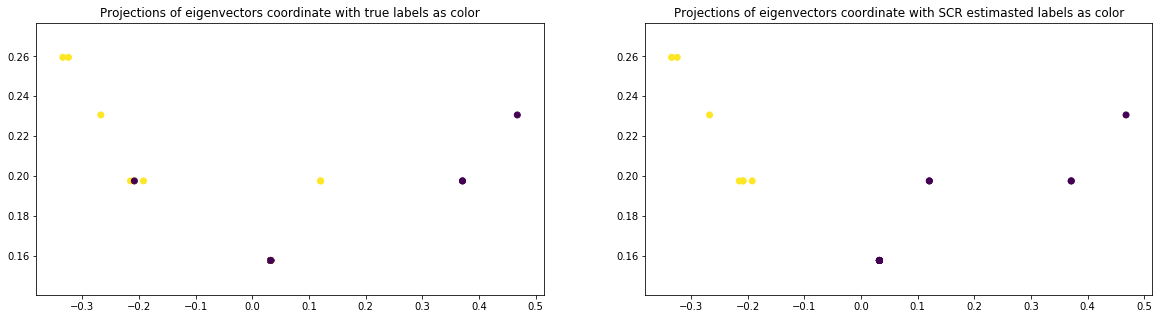

In [8]:
# Test SCR

print('True Communities:')
print(graph.labels)

# 1. Compute eigenvalues of Regularized Clustering
Eig, D = eig_laplacian_regularized(graph.adjency_matrix, k=2, tau=tau)

# 2. Train Kmeans on the two first eigenvectors (Z with k=2)
Kmeans = KMeans(n_clusters=2, random_state=37, init ='random', n_init = 40).fit(Eig[1])

print('Estimation:')
print(Kmeans.labels_*2-1)


print('Normalized Mutual Score of SCR estimate: {:.4f}'.format(graph.NMI(Kmeans.labels_*2-1)))


plt.figure(figsize=(20,5))    
plt.subplot(121)
plt.title('Projections of eigenvectors coordinate with true labels as color')
plt.scatter(Eig[1][:,0], Eig[1][:,1], c = graph.labels)
plt.subplot(122)
plt.title('Projections of eigenvectors coordinate with SCR estimasted labels as color')
plt.scatter(Eig[1][:,0], Eig[1][:,1], c = Kmeans.labels_*2-1)
plt.show()

In [20]:
def SCR_prediction(adjency_matrix, rs=37):
    Eig, D = eig_laplacian_regularized(adjency_matrix, k=2, tau = tau)
    Kmeans = KMeans(n_clusters=2, random_state=rs, init ='random', n_init=100).fit(Eig[1])
    return Kmeans.labels_*2-1

One way to evaluate the score of this community detection method is to use the Normalized Mutual Information Score (provided in SkLearn for instance), that will compare the labelisation obtained via our Regularized Spectral Clustering with the ground truth labelisation from a random graph. To do so, we generate 100 different random graphs, compute the NMI, and plot the boxplot of results. 

Widget Javascript not detected.  It may not be installed or enabled properly.


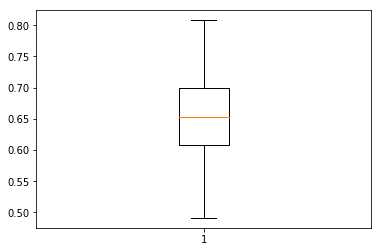

In [10]:
NMI_values = []
np.random.seed(8)

for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM
    SCR_pred = SCR_prediction(graph.adjency_matrix, rs=i)
    NMI_values.append(graph.NMI(SCR_pred))

plt.boxplot(NMI_values)
plt.show()

**Remarks :**

Without regularization, leadings eigenvectors of the Laplacian of A tends to localize around the small connected components which leads to inconsistency in the spectral clustering. At first, I implemented the spectral clustering without regularization, and I had a hard time when some "misfits nodes" where present, ie nodes with degree zero for instance.

In addition, the Laplacian formula from [1] differs from the one seen in class. One chosed to use another formula found in the literature

$$L = I - D^{1/2}AD^{1/2}$$

which gave us better empirical results.

#### B. Approximate Extreme Points (AEP)

The Approximate Extreme Points procedure is based on a geometric property of the feasible set that we obtain by projecting the original space into a 2-dimensional space. Indeed, for the SBM model with two communities, one can verify that $U_{\mathbb{E}A}[-1,1]^n$ is a parallelogram. One can then directly approximates the extreme points of the parallelogram (which are $\{U_{\mathbb{E}A}1, -U_{\mathbb{E}A}1, U_{\mathbb{E}A}c, -U_{\mathbb{E}A}c\}$) among which one is the projection of the true community vector $c$.

Here, the idea is to first use $(D^{1/2}u_1, D^{1/2}u_2)$ instead of $(u_1,u_2)$ which are the two leading eigenvectors of the regularized Laplcacian of A. These vectors are the rows of the projection matrix $U_A$ such that one can project the cube $[-1,1]^n$ into a 2d subspace. 

The estimation of the label vectors is then given by the following formula : 

$$ \begin{array}{ccl}
\hat{c} &=& argmax_{e \in \{-1,1\}^n}<U_Ae, (U_A 1)^{\perp}>\\
&=& \mbox{sign}(u_1^T1u_2 - u_2^T1u_1)
\end{array}$$

This method of estimation, contrary to K-means, is deterministic and only based on the geometric property of $U_A$.

In [6]:
def U_from_laplacian_regularized(A, k=2, tau = 0.001):
    Eig, D = eig_laplacian_regularized(A, k=2, tau=tau)
    return np.dot(D,Eig[1])


# Test: Compute the prediction using the formula above
graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=-1)
U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
c_pred = np.dot(U_A[:,0].T, np.ones(n)) * U_A[:,1] -  np.dot(U_A[:,1].T, np.ones(n)) * U_A[:,0]
c_pred = np.sign(c_pred)

print('Normalized Mutual Score of AEP estimate: {:.4f}'.format(graph.NMI(c_pred)))

Normalized Mutual Score of AEP estimate: 0.7286


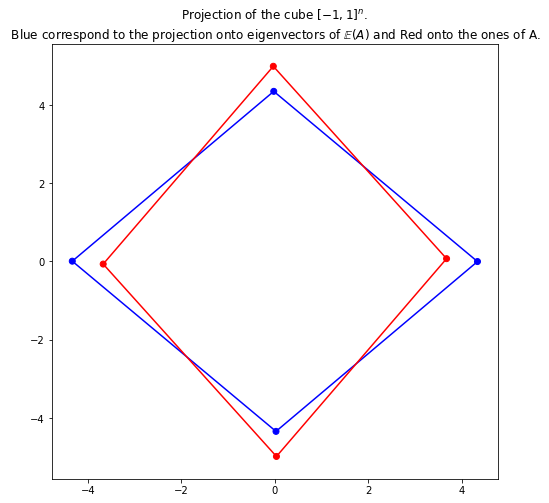

In [7]:
# Plot of the 2D projection 

def get_expected_adjency_matrix(it=100):
    E_A = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=-1).adjency_matrix
    for i in tqdm.tqdm_notebook(range(1,it)):
        E_A += Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=-1).adjency_matrix
    E_A /= it
    return E_A

def get_points(U):

    c_pred = np.dot(U[:,0].T, np.ones(len(U))) * U[:,1] -  np.dot(U[:,1].T, np.ones(len(U))) * U[:,0]
    c_pred = np.sign(c_pred)
    
    constant_pos = np.dot(U.T,[1]*len(U))
    constant_neg = np.dot(U.T,[-1]*len(U))

    pred_pos = np.dot(U.T,c_pred)
    pred_neg = np.dot(U.T,np.multiply(c_pred,-1))
    
    return np.array([constant_pos, constant_neg, pred_pos, pred_neg])


E_A = get_expected_adjency_matrix()
U_EA = U_from_laplacian_regularized(E_A, 2, tau = tau)

points_EA = get_points(U_EA)
points_A = get_points(U_A)

plt.figure(figsize=(8,8))
plt.title('Projection of the cube $[-1,1]^n$. \n Blue correspond to the projection onto eigenvectors of $\mathbb{E}(A)$\
 and Red onto the ones of A. ')
for i,points in enumerate([points_EA, points_A]):
    c = ['b','r'][i]

    plt.scatter(points[:,0], points[:,1], color= [c,c,c,c])
    plt.plot(points[[1,2],0],points[[1,2],1], color=c)
    plt.plot(points[[1,3],0],points[[1,3],1], color=c)
    plt.plot(points[[0,2],0],points[[0,2],1], color=c)
    plt.plot(points[[0,3],0],points[[0,3],1], color=c)

plt.show()

As a remark, the next strategy will be the Extreme Points without Approximation. One will remark that the projection using AEP isn't as good as with EP

In [8]:
def AEP_prediction(adjency_matrix):
    U_A = U_from_laplacian_regularized(adjency_matrix, 2, tau = tau)
    c_pred = np.dot(U_A[:,0].T, np.ones(len(adjency_matrix))) * U_A[:,1] -  np.dot(U_A[:,1].T, np.ones(len(adjency_matrix))) * U_A[:,0]
    c_pred = np.sign(c_pred)
    return c_pred

Widget Javascript not detected.  It may not be installed or enabled properly.


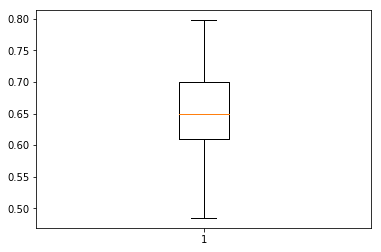

In [14]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM
    AEP_pred = AEP_prediction(graph.adjency_matrix)
    NMI_values.append(graph.NMI(AEP_pred))

plt.boxplot(NMI_values)
plt.show()

#### C. Extreme Points (EP)

Applying theorem 2.2, the authors of [1] showed that

**Theorem 3.1** :

Let A be the adjency matrix genereated from the DCSBM with $\lambda_n$ growing at least as $\log^2n$ as $n \to \inf$.
Let $U_A$ be an approximation of $U_{\mathbb{E}(A)}$ abd e* the label vector with $f_A = Q_{DC}$.
Then for any $\delta \in (0,1)$, there exists a constant $M=M(r, w, \pi, \xi, \delta) > 0$ such that with proba at least $1- \delta$, we have : 

$$ \frac{1}{n}||c - e^*||^2 \leq M \log n \left( \lambda_n^{-1/2} + || U_A -  U_{\mathbb{E}(A)}||\right)$$

In particular, if $U_A$ is a matrix whose row vectors are leading eigenvectors of A, then the fraction of mis-clustered nodes is bounded by $M \frac{ \log n}{\sqrt{\lambda_n}}$


**Theorem 3.2** :

Let A be the adjency matrix genereated from the SBM with $\lambda_n$ growing at least as $\log^2n$ as $n \to \inf$.
Let $U_A$ be an approximation of $U_{\mathbb{E}(A)}$ abd e* the label vector with $f_A = Q_{BM}$.
Then for any $\delta \in (0,1)$, there exists a constant $M=M(r, w, \pi, \xi, \delta) > 0$ such that with proba at least $1- n^{-\delta}$, we have : 

$$ \frac{1}{n}||c - e^*||^2 \leq M \log n \left( \lambda_n^{-1/2} + || U_A -  U_{\mathbb{E}(A)}||\right)$$

In particular, if $U_A$ is a matrix whose row vectors are leading eigenvectors of A, then the fraction of mis-clustered nodes is bounded by $M \frac{ \log n}{\sqrt{\lambda_n}}$

In practice, for the specific case of 2 communities : 

1. use $(D^{1/2}u_1, D^{1/2}u_2)$  to compute the $U_A$ matrix (Similarly to AEP)
2. Sort angles between columns vector of $U_A$ and the $x$-axis.

In [9]:
# Functions used to find the vertices of the projection

def Uvertices(U):
    """ Returns the list of projection vertices """
        
    col_vect = np.concatenate((U, -U), axis=0)
    
    # sort the angles between column vectors and x-axis
    angles_ = [phase(complex(vec[0], vec[1])) for vec in col_vect]
    angles_ = [ang if ang>0 else 2*np.pi+ang for ang in angles_]
    indices = np.argsort(angles_)
    
    # vertex with smallest y coordinate
    ys = U[:,1]
    vert = np.dot(U.T, -np.sign(ys))
    
    True_vect = [-np.sign(ys)]  # vectors whose projections are vertices
    proj = [vert]  # projections in 2D
    
    for index in indices:  # iteratively find the vertices of the space projection
        index %= len(U)
        new_vec = np.copy(True_vect[-1])
        new_vec[index] *= -1  # modify the corrsponding element
        True_vect.append(new_vec)
        proj.append(np.dot(U.T, new_vec))

    return True_vect[:-1], np.array(proj[:-1])

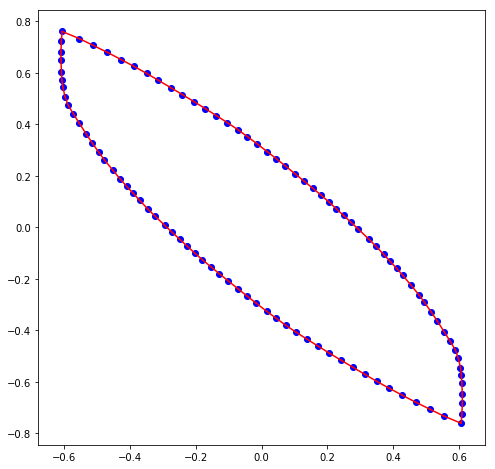

In [16]:
True_vect, proj = Uvertices(U_A[:50])

plt.figure(figsize=(8,8))
plt.scatter(proj[:,0], proj[:,1], color= 'b')
for i in range(len(proj)-1):
    plt.plot(proj[[i,i+1],0],proj[[i,i+1],1], color='r')
plt.plot(proj[[-1,0],0],proj[[-1,0],1], color='r')
    
plt.show()

In [10]:
def EP_prediction(adjency_matrix, func):
    U_A = U_from_laplacian_regularized(adjency_matrix, 2, tau = tau)
    True_vect, proj = Uvertices(U_A)
    obj = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(vect) for vect in True_vect)
    return True_vect[np.argmax(obj)]

Widget Javascript not detected.  It may not be installed or enabled properly.


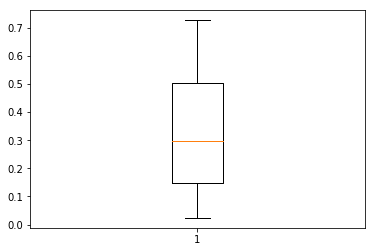

In [18]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM
    EP_pred = EP_prediction(graph.adjency_matrix, lambda e: graph.dcsbm_proflikelihood(e))
    NMI_values.append(graph.NMI(EP_pred))
    
plt.boxplot(NMI_values)
plt.show()

#### D. Unconditional Pseudo Likelihood (UPL)


In order to understand the procedure behind the Unconditional Pseudo Likelihood, one is invited to look a the paper *PSEUDO-LIKELIHOOD METHODS FOR COMMUNITY DETECTION IN LARGE SPARSE NETWORKS* by A. Amini *et al* (https://arxiv.org/pdf/1207.2340.pdf) from where we got inspired so as to implement the procedure (based on a standard EM algorithm). The optimization of UPL will be used in comparison with methods when the underlying graph model is the SBM.

First, let's introduce the following notations :

- The node degree $d_i = \sum_k b_{ik}$
- $b_{ik} = \sum_j A_{ij}I(e_j=k)$ is the number of edges from node $i$ to community $k$ 
- The estimated labeling vector $e = (e_1, ..., e_n)$.
- The actual community vector $c = (c_1, ..., c_n)$.
- $R_{ka}=\frac{1}{n} \sum_{i=1}^{n} I(e_i=k, c_i=a)$ and $R=(R_{ka})_{1\leq k, a\leq K}$ with $K$ the number of communities (assumed to be equal to $2$).
- $\lambda_{lk} = n R_{k\cdot}P_{\cdot l}$ with $P$ the probability matrix of the SBM.
- $\lambda_k=\sum_k \lambda_{lk}$
- $n_k(e) = \sum_{i=1}^n I(e_i=k)$, $n_{kl}(e)=n_k(e)n_l(e)$ if $k\neq l$ and $n_{kk}(e)=n_k(e)(n_k(e)-1)$.


where the notation $A_{k\cdot}$ indicates the $k^{th}$ row of the matrix $A$ and $A_{\cdot l}$ its $l^{th}$ column.

Then, the Unconditional pseudo log-likelihood is given by: 

$$ \begin{array}{ccl}
l_{UPL}(\pi, \theta,(b_i)) & = & \sum_{i=1}^{n} \log\left( \sum_{l=1}^{K} \pi_l e^{-\lambda_l}\prod_{k=1}^{K} \lambda_{lk}^{b_{ik}} \right) \\
 & = & \sum_{i=1}^{n} \log\left( \sum_{l=1}^{2} \pi_l e^{-\lambda_l} \prod_{k=1}^{2} \lambda_{lk}^{b_{ik}} \right)\\
 & = & \sum_{i=1}^{n} \log\left(\pi_1 e^{-\lambda_1} \lambda_{11}^{b_{i1}}\lambda_{12}^{b_{i2}} + \pi_2 e^{-\lambda_2}\lambda_{21}^{b_{i1}}\lambda_{22}^{b_{i2}} \right)
\end{array} $$

The UPL algorithm optimizing the previous quantity, based on an EM algorithm for mixture models, is then as follows: 

- First, initialize $e = (e_1, ..., e_n)$ as the output of SCR and take $\hat{\pi}_l=\frac{n_l}{n}$, $\hat{R}=diag(\hat{\pi}_1,...,\hat{\pi}_K)$, $\hat{P}_{lk}=\frac{O_{lk}}{n_{lk}}$, $\hat{\lambda}_{lk} = n \hat{R}_{k\cdot}\hat{P}_{\cdot l}$.

- Then, repeat T times:

    1. compute the values$(b_{ik})$.
    
    2. using current estimate $\hat{\pi}_k$ and $\hat{\lambda}_{lk}$, compute: 
$$\pi_{il} =\frac{\hat{\pi_l}\prod_{m=1}^{K} e^{b_{im}\log(\hat{\lambda}_{lm})-\hat{\lambda}_{lm}} } {\sum_{k=1}^{K} \hat{\pi_k}\prod_{m=1}^{K}e^{b_{im}\log(\hat{\lambda}_{km})-\hat{\lambda}_{km}}}$$

    3. given probabilities : update parameters values as follow : 
$$\hat{\pi}_l = \frac{1}{n} \sum_{i=1}^{n} \hat{\pi}_{il}, \quad \hat{\lambda}_{lk} = \frac{\sum_i \hat{\pi}_{il}b_{ik}}{\sum_i \hat{\pi}_{il}}$$

    4. Return to step 2 unless the parameters estimates have converged.
    
    5. Update labels by $e_i = argmax_l\ \hat{\pi_{il}}$.
    
    6. Update $\hat{P}$ as follows and return to step 1: 
$$\hat{P}_{lk}=\frac{\sum_{ij}A_{ij}\hat{\pi}_{il} \hat{\pi}_{jk}}{n_{lk}(e)}$$

#### Implementation

In [11]:
def prod_exp(lambda_l, bi):
    prod = 1
    for m in range(len(lambda_l)):
        prod = prod*np.exp(bi[m]*np.log(lambda_l[m]) - lambda_l[m] )
    return prod

def UPL_prediction(adjency_matrix, rs=37, iteration=20, epsilon=0.01):
    SCR_pred = SCR_prediction(adjency_matrix, rs=rs)
    
    #Initialization of e, pu, R, P, lambda
    e = SCR_pred
    n = len(e)

    n1 = np.sum([node==1 for node in e])
    pi = np.array([(n-n1)/n, n1/n])
    R = np.diag(pi)
    P = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            olk = np.sum([adjency_matrix[i,j] for i in range(n) for j in range(n) if (e[i]==2*l-1 and e[j]==2*k-1)])
            if k==l:
                n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                P[l,k] = olk/(n_k*(n_k-1))
            else:
                n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                n_l = np.sum([node_comm==2*l-1 for node_comm in e])
                P[l,k] = olk/(n_k*n_l)
    lambda_ = n*np.dot(R, P).T
    
    pi_table = np.zeros((n,2))
    b = np.zeros((n,2))

    # Repeat the EM steps
    for iterations in range(iteration):
        
        #Step 1 : Compute block sum b_il
        for i in range(n):
            for k in range(2):
                b[i,k] = np.sum([adjency_matrix[i,j] for j in range(n) if e[j]==2*k-1])

        old_pi = [100, 100]
        new_pi = pi
        dist = 100
        
        # Until convergence
        while dist > epsilon:
            
            # Step 2 : estimate probabilities for node labels, pi_table
            for i in range(n):
                C = pi[0] * prod_exp(lambda_[0,:], b[i,:]) + pi[1] * prod_exp(lambda_[1,:], b[i,:])
                for l in range(2):
                    pi_il = pi[l] * prod_exp(lambda_[l,:], b[i,:])
                    pi_il /= C 
                    pi_table[i,l] = pi_il
    
            # Step 3 : Update parameters values pi and lambda_
            for l in range(2):
                pi[l] = np.mean(pi_table[:,l])
                for k in range(2):
                    lambda_[l,k] =  np.dot(pi_table[:,l].T,b[:,k]) / pi_table[:,l].sum()
                    
            # Step 4 : wait fo the parameters estimates to converge
            old_pi = new_pi
            new_pi = pi
            dist = np.sqrt(np.sum( (new_pi - old_pi)**2 ))
        
        # Step 5. Update Labels e and return to step 1
        e = np.argmax(pi_table, axis=1)*2 - 1
        
        if iterations < iteration - 1:
            R = np.diag(pi)
            P = np.zeros((2,2))
            for l in range(2):
                for k in range(2):
                    olk = np.sum([adjency_matrix[i,j]*pi_table[i,l]*pi_table[j,k]
                                  for i in range(n) for j in range(n)])
                    if k==l:
                        n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                        P[l,k] = olk/(n_k*(n_k-1))
                    else:
                        n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                        n_l = np.sum([node_comm==2*l-1 for node_comm in e])
                        P[l,k] = olk/(n_k*n_l)
            lambda_ = n*np.dot(R, P).T
        

    return e

Widget Javascript not detected.  It may not be installed or enabled properly.


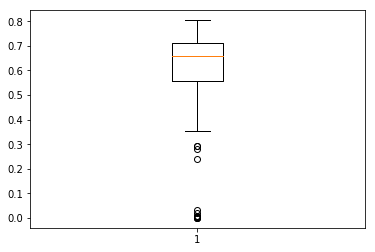

In [20]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM
    UPL_pred = UPL_prediction(graph.adjency_matrix, rs=i)
    NMI_values.append(graph.NMI(UPL_pred))
    
plt.boxplot(NMI_values)
plt.show()

#### E. Conditional Pseudo Likelihood (CPL)

The Conditional Pseudo Likelihood procedure is very simiral to the conditional one.
Here we want to maximize the following (Conditional) Pseudo log likelihood instead: 

$$ \begin{array}{ccl}
l_{UPL}(\pi, \Lambda,(b_i)) & = & \sum_{i=1}^{n} \log\left( \sum_{l=1}^{K} \pi_l \prod_{k=1}^{K} \theta_{lk}^{b_{ik}} \right) \\
 & = & \sum_{i=1}^{n} \log\left( \sum_{l=1}^{2} \pi_l \prod_{k=1}^{2} \theta_{lk}^{b_{ik}} \right)\\
 & = & \sum_{i=1}^{n} \log\left(\pi_1 \theta_{11}^{b_{i1}}\theta_{12}^{b_{i2}} + \pi_2 \theta_{21}^{b_{i1}}\theta_{22}^{b_{i2}} \right)
\end{array} $$

where $\theta_{lk}=\frac{\lambda_{lk}}{\lambda_l}$.

It is the same algorithm as for UPL but we replace steps 2 and 3 by the following ones: 

2. Using current parameter estimatee $\hat{\pi}_k$ and  $\hat{\theta}_{lk}$, we estimates the node labels by: 

$$ \hat{\pi}_{il} = \frac{\hat{\pi_l}\prod_{m=1}^{K} \hat{\theta}_{lm}^{b_{im}}}{\sum_{k=1}^{K} \hat{\pi_k}\prod_{m=1}^{K}\hat{\theta}_{km}^{b_{im}}}$$

3. Given label probabilities, we update the parameter values by : 

$$\hat{\pi}_l = \frac{1}{n} \sum_{i=1}^{n} \hat{\pi}_{il}$$

$$\hat{\lambda}_{lk} = \frac{\sum_i \hat{\pi}_{il}b_{ik}}{\sum_i \hat{\pi}_{il}d_i}$$

Other steps remain the exactly the sames.

In [12]:
def prod_exp2(vector, exp):
    prod = 1
    for i in range(len(vector)):
        prod = prod*(vector[i]**exp[i])
    return prod


def CPL_prediction(adjency_matrix, rs=37, iteration=20, epsilon=0.01):
    SCR_pred = SCR_prediction(adjency_matrix, rs=rs)
    
    #Initialization of e, pu, R, P, lambda
    e = SCR_pred
    n = len(e)

    n1 = np.sum([node==1 for node in e])
    pi = np.array([(n-n1)/n, n1/n])
    R = np.diag(pi)
    P = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            olk = np.sum([adjency_matrix[i,j] for i in range(n) for j in range(n) if (e[i]==2*l-1 and e[j]==2*k-1)])
            if k==l:
                n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                P[l,k] = olk/(n_k*(n_k-1))
            else:
                n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                n_l = np.sum([node_comm==2*l-1 for node_comm in e])
                P[l,k] = olk/(n_k*n_l)
    lambda_ = n*np.dot(R, P).T
    
    theta = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            theta[l,k] = lambda_[l,k]/lambda_[l,:].sum()
    
    pi_table = np.zeros((n,2))
    b = np.zeros((n,2))

    # Repeat the EM steps
    for iterations in range(iteration):
        
        #Step 1 : Compute block sum b_il
        for i in range(n):
            for k in range(2):
                b[i,k] = np.sum([adjency_matrix[i,j] for j in range(n) if e[j]==2*k-1])

        old_pi = [100, 100]
        new_pi = pi
        dist = 100
        
        # Until convergence
        while dist > epsilon:     
            
            # Step 2 : estimate probabilities for node labels, pi_table
            for i in range(n):
                C = pi[0] * prod_exp2(theta[0,:], b[i,:])+pi[1] * prod_exp2(theta[1,:], b[i,:])
                for l in range(2):
                    pi_il = pi[l] * prod_exp2(theta[l,:], b[i,:])
                    pi_il /= C 
                    pi_table[i,l] = pi_il
    
            # Step 3 : Update parameters values pi and lambda_
            for l in range(2):
                pi[l] = np.mean(pi_table[:,l])
                for k in range(2):
                    theta[l,k] =  np.dot(pi_table[:,l].T,b[:,k]) / np.dot(pi_table[:,l].T,np.sum(b, axis=1))
                    
            # Step 4 : wait fo the parameters estimates to converge
            old_pi = new_pi
            new_pi = pi
            dist = np.sqrt(np.sum( (new_pi - old_pi)**2 ))
        
        # Step 5. Update Labels e and return to step 1
        e = np.argmax(pi_table, axis=1)*2 - 1
        
        if iterations < iteration - 1:
            R = np.diag(pi)
            P = np.zeros((2,2))
            for l in range(2):
                for k in range(2):
                    olk = np.sum([adjency_matrix[i,j]*pi_table[i,l]*pi_table[j,k]
                                  for i in range(n) for j in range(n)])
                    if k==l:
                        n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                        P[l,k] = olk/(n_k*(n_k-1))
                    else:
                        n_k = np.sum([node_comm==2*k-1 for node_comm in e])
                        n_l = np.sum([node_comm==2*l-1 for node_comm in e])
                        P[l,k] = olk/(n_k*n_l)
            lambda_ = n*np.dot(R, P).T
            theta = np.zeros((2,2))
            for l in range(2):
                for k in range(2):
                    theta[l,k] = lambda_[l,k]/lambda_[l,:].sum()
        
    return e

Widget Javascript not detected.  It may not be installed or enabled properly.


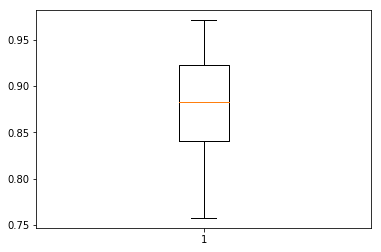

In [22]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=0, pi=pi)  #SBM
    CPL_pred = CPL_prediction(graph.adjency_matrix, rs=i)
    NMI_values.append(graph.NMI(CPL_pred))
    
plt.boxplot(NMI_values)
plt.show()

#### F. SDP optimization (SDP)

In [13]:
from cvxpy import *
print(installed_solvers())

def SDP_prediction(adjency_matrix):  
    u, v = adjency_matrix.shape
    dia = np.diag_indices(u) # indices of diagonal elements
    dia_sum = sum(adjency_matrix[dia]) # sum of diagonal elements
    lambda_ = (np.sum(adjency_matrix) - dia_sum) / (u * (u-1)) # average degree of the graph 
    
    Z = Variable((u, v), PSD=True)
    obj = Maximize(
        trace(
            matmul(Z.T,
                   adjency_matrix-lambda_*np.ones((u,v)))
        )
    )
    constraints = [diag(Z)<=1]
    
    prob = Problem(obj, constraints)
    prob.solve(solver=SCS)
    if prob.status != 'optimal':
        print('CVXPY failed to reach optimal value')
        
    return np.sign(eigsh(Z.value, 1, which='LM')[1].T[0])

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'OSQP']


Widget Javascript not detected.  It may not be installed or enabled properly.


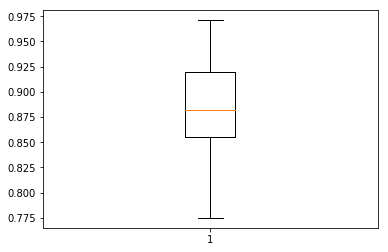

In [24]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=0, pi=pi)  #SBM
    SDP_pred = SDP_prediction(graph.adjency_matrix)
    NMI_values.append(graph.NMI(SDP_pred))
    
plt.boxplot(NMI_values)
plt.show()

### Numerical comparaison of the different procedures

#### The stochastic block model

In [25]:
SCR_values = []
AEP_values = []
EP_values = []
CPL_values = []
SDP_values = []

for i in tqdm.tqdm_notebook(range(50)):
    
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=0, pi=pi)  #SBM

    #SCR
    SCR_pred = SCR_prediction(graph.adjency_matrix, rs=i)
    SCR_values.append(graph.NMI(SCR_pred))

    #AEP
    AEP_pred = AEP_prediction(graph.adjency_matrix)
    AEP_values.append(graph.NMI(AEP_pred))

    #EP
    EP_pred = EP_prediction(graph.adjency_matrix, lambda e: graph.sbm_proflikelihood(e))
    EP_values.append(graph.NMI(EP_pred))
    
    #CPL
    CPL_pred = CPL_prediction(graph.adjency_matrix, rs=i)
    CPL_values.append(graph.NMI(CPL_pred))
    
    #SDP
    SDP_pred = SDP_prediction(graph.adjency_matrix)
    SDP_values.append(graph.NMI(SDP_pred))

Widget Javascript not detected.  It may not be installed or enabled properly.


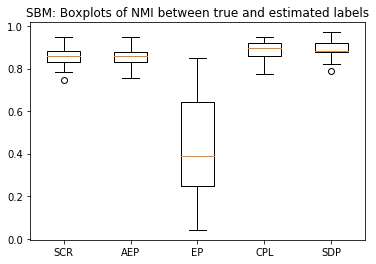

In [26]:
plt.boxplot([SCR_values,AEP_values,EP_values,CPL_values,SDP_values])
plt.title('SBM: Boxplots of NMI between true and estimated labels')
plt.xticks([1, 2, 3, 4, 5], ['SCR', 'AEP', 'EP', 'CPL', 'SDP'])
plt.show()

#### The degree-corrected stochastic block model

In [27]:
SCR_values = []
AEP_values = []
EP_values = []
UPL_values = []
SDP_values = []

for i in tqdm.tqdm_notebook(range(50)):
    
    graph = Graph_Model(n = n, lambda_n = lambda_n, r = r, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM

    #SCR
    SCR_pred = SCR_prediction(graph.adjency_matrix, rs=i)
    SCR_values.append(graph.NMI(SCR_pred))

    #AEP
    AEP_pred = AEP_prediction(graph.adjency_matrix)
    AEP_values.append(graph.NMI(AEP_pred))

    #EP
    EP_pred = EP_prediction(graph.adjency_matrix, lambda e: graph.sbm_proflikelihood(e))
    EP_values.append(graph.NMI(EP_pred))
    
    #UPL
    UPL_pred = UPL_prediction(graph.adjency_matrix, rs=i)
    UPL_values.append(graph.NMI(UPL_pred))
    
    #SDP
    SDP_pred = SDP_prediction(graph.adjency_matrix)
    SDP_values.append(graph.NMI(SDP_pred))

Widget Javascript not detected.  It may not be installed or enabled properly.


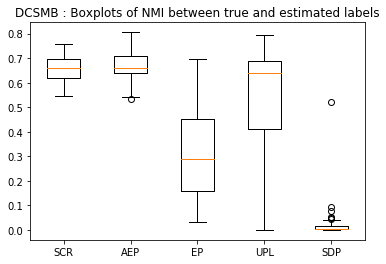

In [28]:
plt.boxplot([SCR_values,AEP_values,EP_values,UPL_values,SDP_values])
plt.title('DCSMB : Boxplots of NMI between true and estimated labels')
plt.xticks([1, 2, 3, 4, 5], ['SCR', 'AEP', 'EP', 'UPL', 'SDP'])
plt.show()

#### Impact of the out-in probability ratio r on the performance

In [29]:
SCR_plt = []
AEP_plt = []
EP_plt = []
UPL_plt = []
SDP_plt = []

for r_test in  tqdm.tqdm_notebook(range(0,45,5)):
    
    r_test/=100
    
    SCR_r = []
    AEP_r = []
    EP_r = []
    UPL_r = []
    SDP_r = []

    for i in range(10):

        graph = Graph_Model(n = n, lambda_n = lambda_n, r = r_test, w1=w1, w2=w2, gamma=gamma, pi=pi)  #DCSBM

        #SCR
        SCR_pred = SCR_prediction(graph.adjency_matrix, rs=i)
        SCR_r.append(graph.NMI(SCR_pred))

        #AEP
        AEP_pred = AEP_prediction(graph.adjency_matrix)
        AEP_r.append(graph.NMI(AEP_pred))

        #EP
        EP_pred = EP_prediction(graph.adjency_matrix, lambda e: graph.sbm_proflikelihood(e))
        EP_r.append(graph.NMI(EP_pred))

        #CPL
        UPL_pred = UPL_prediction(graph.adjency_matrix, rs=i)
        UPL_r.append(graph.NMI(UPL_pred))

        #SDP
        SDP_pred = SDP_prediction(graph.adjency_matrix)
        SDP_r.append(graph.NMI(SDP_pred))
    
    SCR_plt.append(np.mean(SCR_r))
    AEP_plt.append(np.mean(AEP_r))
    EP_plt.append(np.mean(EP_r))
    UPL_plt.append(np.mean(UPL_r))
    SDP_plt.append(np.mean(SDP_r))

Widget Javascript not detected.  It may not be installed or enabled properly.


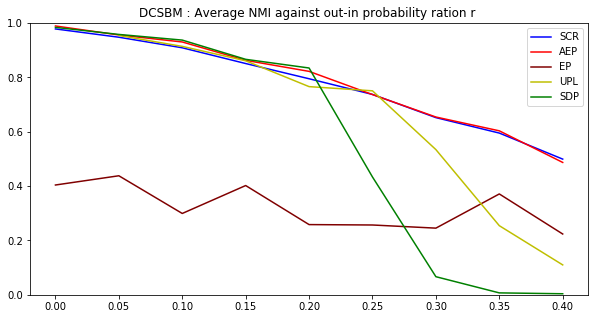

In [30]:
plt.figure(figsize=(10,5))
plt.ylim(0.4,1.01)
xaxis = [i/100 for i in range(0,45,5)]

plt.plot( xaxis, SCR_plt, color = 'b', label = 'SCR')
plt.plot(xaxis, AEP_plt, color = 'r', label = 'AEP')
plt.plot(xaxis, EP_plt, color = 'maroon', label = 'EP')
plt.plot(xaxis[1:], UPL_plt[1:], color = 'y', label = 'UPL')  # UPL doesn't work with r=0
plt.plot(xaxis, SDP_plt, color = 'g', label = 'SDP')

plt.legend()
plt.title('DCSBM : Average NMI against out-in probability ration r ')
plt.ylim((0, 1))
plt.show()

## 6. Real-word network Data : PolBlogs

As proposed in the paper, the differents methods have been applied to a real-word network dataset. This network, *polblogs*, is composed of blogs about the US politics and hyperlinks between blog.

In [14]:
import networkx as nx
import zipfile

s = r'./polblogs.zip'
zf = zipfile.ZipFile(s) 
txt = zf.read('polblogs/polblogs.txt').decode() 
gml = zf.read('polblogs/polblogs.gml').decode()  

gml = gml.split('\n')[1:]
gml.insert(2, "  multigraph 1")

G = nx.parse_gml(gml) 
G=G.to_undirected()

In [32]:
print(txt)

Political blogosphere Feb. 2005
Data compiled by Lada Adamic and Natalie Glance

Node "value" attributes indicate political leaning according to:

  0 (left or liberal)
  1 (right or conservative)

Data on political leaning comes from blog directories as indicated.  Some
blogs were labeled manually, based on incoming and outgoing links and posts
around the time of the 2004 presidential election.  Directory-derived
labels are prone to error; manual labels even more so.

Links between blogs were automatically extracted from a crawl of the front
page of the blog.

These data should be cited as Lada A. Adamic and Natalie Glance, "The
political blogosphere and the 2004 US Election", in Proceedings of the
WWW-2005 Workshop on the Weblogging Ecosystem (2005).



This is a two-communities network whose labels we aim at recovering using optimization of different criteria we implemented earlier in the notebook. It is indeed interesting to go beyond the classifical framework of generated random graph and see how those differents react on a real-world graph data. 

To reproduce excatly the experiments from the paper, we'll follow the same step : first we ignore hyperlinks by keeping only the largest connected component of the network composed of 1222 nodes (this is accessible via the command *nx.connected_component_subgraphs*)

In [15]:
a = nx.connected_component_subgraphs(G)
a = next(a)

In [16]:
G_ = list(nx.connected_component_subgraphs(G))
print(len(G_))

Gc = list(nx.connected_component_subgraphs(G))[np.argmax([x.size() for x in G_])]
print(len(Gc.nodes()))

268
1222


### Representation of the polblogs network.

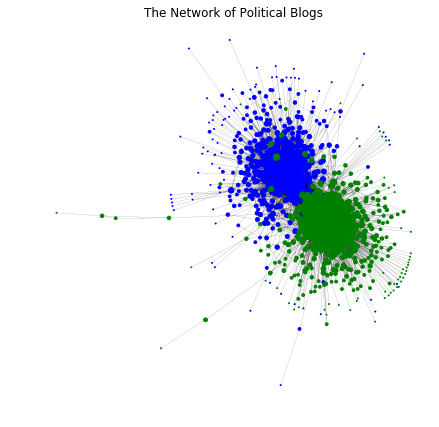

In [17]:
d = nx.degree(Gc)
color_map = []
for node in Gc.nodes():
    if Gc.nodes[node]['value']==0:
        color_map.append('blue')
    else: color_map.append('green')     

        
dd = {}
for key, value in d:
    dd[key] = value

options = {
    'line_color': 'black',
    'linewidths': 1,
    'alpha':1 ,
    'width':0.1,
    # Node diamaters are proportinal to the log of node's degree.
    'node_size': [(0.1+np.max([0,np.log(dd[node])]))*10 for node in Gc.nodes()],
    # colors represent the two labels of communities
    'node_color': color_map
}

# We fix the layout to have the same disposition of the nodes once and for all
np.random.seed(1)
fixed_layout = nx.spring_layout(Gc)

plt.figure(figsize=(7,7))
plt.title('The Network of Political Blogs')
nx.draw(Gc, fixed_layout , **options) 
plt.show()

In [18]:
def OKL(adjency_matrix, e, comm1, comm2):
    '''Return the number of edges between community comm1 and comm2'''

    indice_1 = [index for index, comm in enumerate(e) if comm == comm1]
    indice_2 = [index for index, comm in enumerate(e) if comm == comm2]

    return np.sum([adjency_matrix[i1, i2] for i1 in indice_1 for i2 in indice_2])

def comm_effectif( e, comm):
    return(np.sum([comm_==comm for comm_ in e]))

def sbm_prof_like(adjacency_matrix, e):
    qbm = 0
    communities = set(e)
    for i in communities:
        for j in communities:
            qbm += OKL(adjacency_matrix, e,i,j)*np.log(OKL(adjacency_matrix, e,i,j)/(comm_effectif(e,i)*comm_effectif(e,i)))
    return(qbm)

In [21]:
n = 1222
adjency_matrix = nx.adjacency_matrix(Gc).todense() + np.identity(1222)
true_labels = [int(Gc.nodes[node]['value']) for node in Gc.nodes()]

#SCR
SCR_pred = SCR_prediction(adjency_matrix)
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = SCR_pred, average_method='arithmetic')
print('NMI SCR = ', NMI)

#AEP
AEP_pred = AEP_prediction(adjency_matrix)
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = AEP_pred, average_method='arithmetic')
print('NMI AEP = ', NMI)

#EP
EP_pred = EP_prediction(adjency_matrix, lambda e: sbm_prof_like(adjency_matrix, e))
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = EP_pred, average_method='arithmetic')
print('NMI EP (SBM Profile Likelihood) = ', NMI)

#CPL
CPL_pred = CPL_prediction(adjency_matrix)
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = CPL_pred, average_method='arithmetic')
print('NMI CPL = ', NMI)

#UPL
UPL_pred = UPL_prediction(adjency_matrix)
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = UPL_pred, average_method='arithmetic')
print('NMI UPL = ', NMI)

#SDP
# SDP_pred = SDP_prediction(adjency_matrix)
# NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = SDP_pred, average_method='arithmetic')
# print('NMI SDP = ', NMI)

NMI SCR =  0.2392710601873821
NMI AEP =  0.6551022169958212
NMI EP (SBM Profile Likelihood) =  0.2698934583635866
NMI CPL =  0.508070530788737
NMI UPL =  0.0


We can now compare results from the paper and the ones we get here : 

**Method** | SCR | AEP | EP | UPL | CPL
- |:-: |:-: |:-: |:-: |:-: 
Paper | 0.290 | 0.674 | 0.278(0.731) | 0.001 | 0.725 
Reproduction| 0.239 | 0.655 | 0.270 | 0.000 | 0.508 


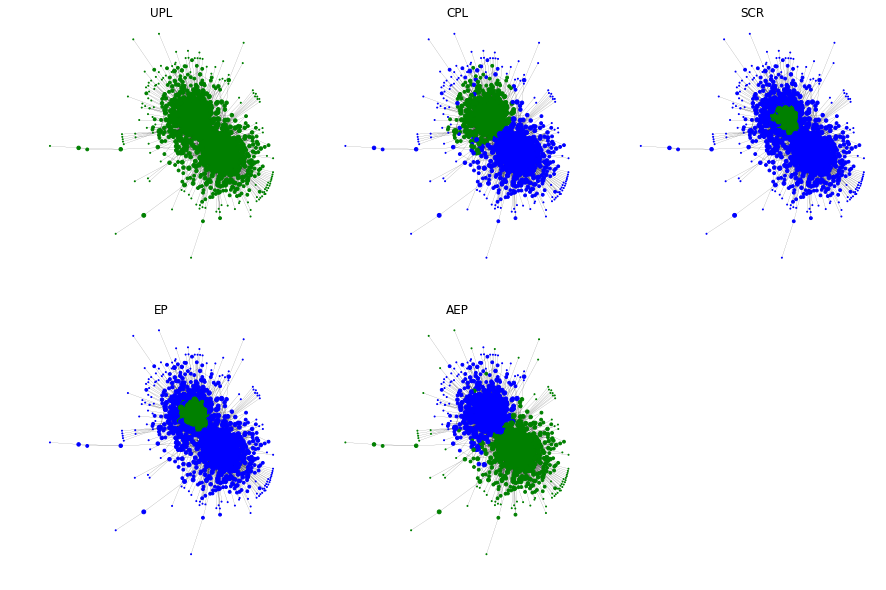

In [30]:
plt.figure(figsize=(15,10))
    
options = {
    'line_color': 'black',
    'linewidths': 1,
    'alpha':1 ,
    'width':0.1,
}

i=1
legends = ['UPL', 'CPL', 'SCR', 'EP', 'AEP']
for pred in [UPL_pred, CPL_pred, SCR_pred, EP_pred, AEP_pred]:
    
    plt.subplot(2,3,i)
    plt.title(legends[i-1])
    
    color_map = []
    for node in range(len(Gc.nodes())):
        if pred[node]==1:
            color_map.append('blue')
        else: color_map.append('green')      

    nx.draw(
        Gc,  fixed_layout ,node_color = color_map,
        node_size=[(0.1+np.max([0,np.log(dd[node])]))*10 for node in Gc.nodes()],
        **options
           ) 
    i+=1

plt.show()